# LightGBM tuning
Goal: tune a LightGBM model with cleaned samples.
***

## Table of Contents 

1. [Intuition Behind Tuning Approach](#1.-Intuition-Behind-Tuning-Approach)
2. [Intuition Behind Evaluation Metrics](#2.-Intuition-Behind-Tuning-Metrics)
3. [Load Data](#3.-Load-Data)
4. [Define Functions](#4.-Define-Functions)
5. [Building a Baseline Model](#5.-Building-a-Baseline-Model)
6. [Equalize Class Imbalance](#6.-Equalize-Class-Imbalance)
7. [Tune Parameters for Overfitting](#7.-Tune-Parameters-for-Overfitting)
<br>7.1 [Overfitting (1)](#7.1-Overfitting-(1))
<br>7.2 [Overfitting (2)](#7.2-Overfitting-(2))
8. [Accurate Predictions and Overfitting](#8.-Accurate-Predictions-and-Overfitting)
9. [Regularization](#9.-Regularization)

## 1. Intuition Behind Tuning Approach
1. Control overfitting and tune parameters for the leaf-wise (best-first) tree.
2. Tune for more accurate predictions and further control overfitting.
3. Regularize the predictions.

## 2. Intuition Behind Evaluation Metrics

Click this [link](https://github.com/ayn28/churn-prediction-modeling/blob/master/model-tuning/XGBoost-tuning.ipynb) or copy and paste the link below into your browser to read about the intuition behind choosing the evaluation metrics. 

https://github.com/ayn28/churn-prediction-modeling/blob/master/model-tuning/XGBoost-tuning.ipynb

## 3. Load Data

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Import cleaned datasets
df = pd.read_csv('data/cleaned_data/og_cleaned_samples.csv', index_col='customerID')
df_cat_encoded = pd.read_csv('data/cleaned_data/num_cleaned_samples.csv', index_col='customerID')

# Create features and target arrays
X = df_cat_encoded.drop(['Churn_Yes', 'gender_Male'], axis=1).values
y = df_cat_encoded.Churn_Yes.values

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

To create our features array, we drop the Churn feature since that is our target variable and we are trying to predict its labels. From our EDA, we determined that a customer's gender likely has no effect on their propensity to churn since it wasn't strongly correlated with other features and had no notable differences in churn rates between genders.
***

### 4. Define Functions

In [12]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Define function to fit a classifier.
def fit_model(clf_name):
    """Fit a classifier to the training data."""
    clf_name.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc'],    # Will document logloss (by default) and AUC
        early_stopping_rounds=10,
        verbose=False
    )

# Define function to calculate evaluation metrics.
def metrics(clf_name, ordered_dict):
    """Calculate and output evaluation metrics."""
    # Print best iteration round number
    best_iteration = clf_name.best_iteration_
    # Calculate AUC, AUCPR, and Logloss
    auc_mtr = [i for i in clf_name.best_score_.values()][0]['auc']
    logloss_mtr = [i for i in clf_name.best_score_.values()][0]['binary_logloss']
    # Calculate AUCPR
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    aucpr_mtr = average_precision_score(y_test, preds)
    print('Best iteration: {} rounds.'.format(best_iteration))
    print('AUC:       {0:.3f}'.format(auc_mtr))
    print('AUCPR:     {0:.3f}'.format(aucpr_mtr))
    print('Logloss:   {0:.3f}'.format(logloss_mtr))
    # Calculate precision, recall, and f1-score
    binary_preds = clf_name.predict(X_test)
    print('Precision: {0:.3f}'.format(precision_score(y_test, binary_preds)))
    print('Recall:    {0:.3f}'.format(recall_score(y_test, binary_preds)))
    print('F1-score:  {0:.3f}'.format(f1_score(y_test, binary_preds)))
    # Append metrics to an ordered dictionary (for plotting)
    ordered_dict['Best_iteration'] = best_iteration
    ordered_dict['AUC'] = round(auc_mtr, 3)
    ordered_dict['AUCPR'] = round(aucpr_mtr, 3)
    ordered_dict['Logloss'] = round(logloss_mtr, 3)
    ordered_dict['Precision'] = round(precision_score(y_test, binary_preds), 3)
    ordered_dict['Recall'] = round(recall_score(y_test, binary_preds), 3)
    ordered_dict['F1_score'] = round(f1_score(y_test, binary_preds), 3)
    
# Define function to plot ROC curve.     
def plot_roc(clf_name):
    """Plot the ROC curve for a given classifier."""
    # Calculate the fpr and tpr for all thresholds of the classification
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure(figsize=(7, 7))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Define function to plot PR curve.
def plot_pr(clf_name):
    """Plot the precision-recall curve for a given classifier."""
    # Calculate the precision and recall for all thresholds of the classification
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    average_precision = average_precision_score(y_test, preds)
    # Plot PR curve
    plt.figure(figsize=(7, 7))
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='AUCPR = %0.3f' % average_precision)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0.5, 0.5],'r--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

# Define function to plot ROC and PR curve.
def plot_roc_pr(clf_name):
    """Plot the ROC and PR-curve for a given classifier."""
    plt.figure(figsize=(14, 7))
    # Plot ROC
    plt.subplot(121)
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # Plot PR curve
    plt.subplot(122)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    average_precision = average_precision_score(y_test, preds)
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='AUCPR = %0.3f' % average_precision)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0.5, 0.5],'r--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    
# Define function to plot metric changes between consecutive iterations.
def plot_consec_metric_delta(label1, dict1, label2, dict2):
    """Plot the metric changes between consecutive iterations."""
    df = pd.DataFrame(
        data=[[val for (metric, val) in dict1.items()],
              [val for (metric, val) in dict2.items()]],
        columns=[metric for (metric, val) in dict1.items()]
    )
    
    # Store best iterations
    bst_iters = list(df['Best_iteration'])
    
    # Drop the 'Best_iteration' column inplace
    df.drop(['Best_iteration'], axis=1, inplace=True)
    
    # Define # of iterations you want to plot
    N = 2
    ind = np.arange(N)    
    
    # Plot metrics
    plt.figure(figsize=(6, 6))
    for metric in list(df.columns):
        plt.plot(ind, df[metric].values, linewidth=1.5, marker='o', label=metric);
    
    plt.xticks(
        ticks=np.arange(N),
        labels=[
            '{}\n{} rounds'.format(label1, bst_iters[0]),
            '{}\n{} rounds'.format(label2, bst_iters[1])
        ])
    
    # Fixed
    plt.title('Evaluation Metrics Over Consecutive Iterations', fontsize=13)
    plt.ylabel('Value', fontsize=12)
    plt.xlabel('Iteration', fontsize=12)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.show()

### 5. Building a Baseline Model
In order to get an idea of the range of precision and recall we would like our model to surpass, we are going to build a baseline model and save its score for later. This score is what we can achieve with no tuning. 

In [4]:
import lightgbm as lgb

# Define baseline parameters
params = {
    'verbosity': 0,
    'seed': 42,
    'objective': 'binary'
}

# Instantiate a classifier (using all default parameters)
clf_baseline = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf_baseline)

# Output evaluation metrics
clf_baseline_dict = OrderedDict()
metrics(clf_baseline, clf_baseline_dict)

Best iteration: 14 rounds.
AUC:       0.841
AUCPR:     0.631
Logloss:   0.435
Precision: 0.684
Recall:    0.390
F1-score:  0.497


### 6. Equalize Class Imbalance
Most notably in this step, we apply more weight to the positive "churn" class. We apply the ratio of negative-to-positive classes to the positive class.

In [5]:
# Load data into Dataset objects (optimized for LightGBM)
# (very memory-efficient b/c it only saves discrete bins)
dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(X_test, label=y_test)

# Balance the positive and negative weights and assign it to the scale_pos_weight parameter
train_labels = dtrain.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
print('Value for scale_pos_weight: {:.2f}'.format(ratio))

Value for scale_pos_weight: 2.76


In [6]:
# Set hyperparameters
# (added the scale_pos_weight parameter)
params = {
    'verbosity': 0,
    'seed': 42,
    'objective': 'binary',
    'scale_pos_weight': 2.76
}

# Instantiate classifier
clf_equalize = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf_equalize)

# Output evaluation metrics 
clf_equalize_dict = OrderedDict()
metrics(clf_equalize, clf_equalize_dict)

Best iteration: 14 rounds.
AUC:       0.837
AUCPR:     0.635
Logloss:   0.469
Precision: 0.552
Recall:    0.742
F1-score:  0.633


Let's compare the baseline model to the equalized model and further analyze the changes.

Baseline model:
Best iteration: 14 rounds.
AUC:       0.841
AUCPR:     0.631
Logloss:   0.435
Precision: 0.684
Recall:    0.390
F1-score:  0.497

Equalized model:
Best iteration: 14 rounds.
AUC:       0.837
AUCPR:     0.635
Logloss:   0.469
Precision: 0.552
Recall:    0.742
F1-score:  0.633


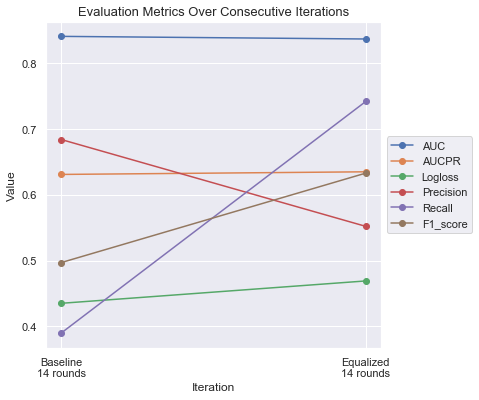

In [14]:
# Print evaluation metrics for baseline model
print('Baseline model:')
metrics(clf_baseline, clf_baseline_dict)

# Print evaluation metrics for equalized model
print('\nEqualized model:')
metrics(clf_equalize, clf_equalize_dict)

# Plot the changes between both iterations
plot_consec_metric_delta('Baseline', clf_baseline_dict, 'Equalized', clf_equalize_dict)

After balancing the classes, the model's ability to classify positive labels increased (increase in recall) at the expense of misclassifying positive labels (decrease in precision).

**Notable observations:**
1. Recall, F1-score, AUCPR increased
2. Precision decreased
***

## 7. Tune Parameters for Overfitting
According to the LightGBM documentation:
<br><br>"LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters.

### 7.1 Overfitting (1)
* **num_leaves**: Max number of leaves in one tree. This is the main parameter to control the complexity of the model.
* **min_child_samples**: Minimal number of data in one leaf. This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. 
* **min_child_weight**: Minimal sum hessian in one leaf used to deal with over-fitting.
* **max_depth**: Limit the max depth for tree model. This is used to deal with over-fitting when data is small. 

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time 

# Set hyperparameters
params = {
    'verbosity': 0,
    'seed': 42,
    'objective': 'binary',
    'scale_pos_weight': 2.76
}

# Parameters to tune 
params_grid = {
    'num_leaves': np.arange(5, 135, 5),
    'min_child_samples': np.arange(1, 50, 1),
    'min_child_weight': np.arange(1, 50, 1),
    'max_depth': np.arange(1, 16, 1)
}

# Peform RandomizedSearchCV to find optimal params
clf_of1_grid = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(**params),
    param_distributions=params_grid,     # RS=param_distributions=; GS=param_grid
    n_iter=100,                          # NO n_iter for GS
    n_jobs=1,                            # NO n_jobs for GS
    scoring='roc_auc',
    cv=5,
    verbose=1
)

# Fit the model
%time clf_of1_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(clf_of1_grid.best_score_))
print('Testing the following params:')
for key, val in clf_of1_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 5min 36s, sys: 5.91 s, total: 5min 42s
Wall time: 48 s
Best AUC score: 0.851
Testing the following params:
	num_leaves: 105
	min_child_weight: 18
	min_child_samples: 32
	max_depth: 2


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   48.0s finished


Best iteration: 14 rounds.
AUC:       0.829
AUCPR:     0.597
Logloss:   0.499
Precision: 0.512
Recall:    0.734
F1-score:  0.604


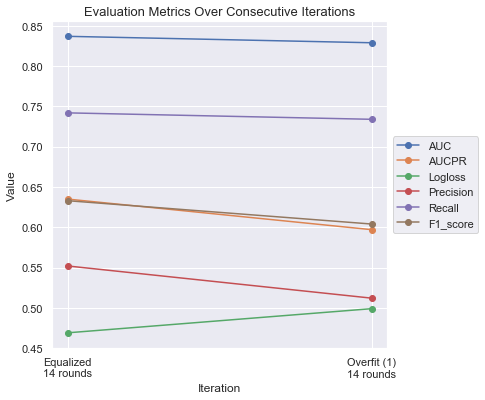

In [18]:
params = {
    'verbosity': 0,
    'seed': 42,
    'objective': 'binary',
    'scale_pos_weight': 2.76,
    'num_leaves': 60,
    'min_child_weight': 20,
    'min_child_samples': 12,
    'max_depth': 2
}

# Instantiate classifier
clf_of1 = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf_of1)

# Output eval metrics
clf_of1_dict = OrderedDict()
metrics(clf_of1, clf_of1_dict)
plot_consec_metric_delta('Equalized', clf_equalize_dict, 'Overfit (1)', clf_of1_dict)

### 7.2 Overfitting (2)
Use bagging and feature sub-sampling to control overfitting:
* **subsample**
* **subsample_freq**
* **colsample_bytree**

## 8. Accurate Predictions and Overfitting
* **learning_rate**
* **n_estimators**
* **max_bin**

## 9. Regularization
* **reg_alpha**
* **reg_lambda**
* **min_split_gain**

***

### Parameters subsample and colsample_bytree

In [ ]:
# Parameters to tune 
params_grid = {
    'subsample':        np.arange(.1, 1.1, .1),
    'colsample_bytree': np.arange(.1, 1.1, .1)
}

# Peform RandomizedSearchCV to find optimal params
clf_grid1 = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(**params),
    param_distributions=params_grid,
    n_iter=150,
    n_jobs=1,
    scoring='roc_auc',
    cv=5,
    verbose=1
)

# Fit the model
%time clf_grid1.fit(X_train, y_train)
clf_gridlist1 = []

print('Best AUC score: {0:.3f}'.format(clf_grid1.best_score_))
print('Best parameters:')
for key, val in clf_grid1.best_params_.items():
    print('\t{}: {}'.format(key, val))
    clf_gridlist1.append(val)
    
# Update parameters 
params['subsample'] = clf_gridlist1[0]
params['colsample_bytree'] = clf_gridlist1[1]

# Instantiate a classifier
clf3 = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf3)

# Output evaluation metrics
print('')
results_dict3 = OrderedDict()
metrics(clf3, results_dict3)
plot_consec_metric_delta(results_dict2, results_dict3)

Recall, AUCPR, and F1 increased with only a minor decrease in precision. Let's use the following values for subsample and colsample_bytree:
* subsample: 0.1
* colsample_bytee: 0.30

### Parameters learning_rate and n_estimators

In [ ]:
# Params to tune
params_grid = {
    'learning_rate': [0.005, 0.05, 0.1, 0.2, 0.3, 0.4],      
    'n_estimators':  np.arange(100, 1000, 200),
    'num_leaves':    [20, 50, 100, 300, 500, 700, 1000]
}

# Peform RandomizedSearchCV to find optimal params
clf_grid2 = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(**params),
    param_distributions=params_grid,
    scoring='roc_auc',
    n_iter=150,
    cv=5,
    verbose=1
)

# Fit the model
%time clf_grid2.fit(X_train, y_train)
clf_gridlist2 = []

print('Best AUC score: {0:.3f}'.format(clf_grid2.best_score_))
print('Best parameters:')
for key, val in clf_grid2.best_params_.items():
    print('\t{}: {}'.format(key, val))
    clf_gridlist2.append(val)
    
# Update parameters 
params['num_leaves'] = clf_gridlist2[0]
params['n_estimators'] = clf_gridlist2[1]
params['learning_rate'] = clf_gridlist2[2]


# Instantiate a classifier
clf4 = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf4)

# Output evaluation metrics
print('')
results_dict4 = OrderedDict()
metrics(clf4, results_dict4)
plot_consec_metric_delta(results_dict3, results_dict4)

#### Additional reference

In [ ]:
# df = pd.DataFrame(
#     data=[[val for (metric, val) in results_dict.items()],
#           [val for (metric, val) in results_dict1.items()]],
#     columns=[metric for (metric, val) in results_dict.items()])

# # Store best iterations
# bst_iters = list(df['Best_iteration'])

# # Drop the 'Best_iteration' column, inplace
# df.drop(['Best_iteration'], axis=1, inplace=True)

# df

In [ ]:
# # Define # of iterations you want to plot
# N = 2

# plt.figure(figsize=(5, 5));
# ind = np.arange(N)

# # Plot metrics
# for metric in list(df.columns):
#     plt.plot(ind, df[metric].values, linewidth=1.5, marker='o', label=metric);

# plt.xticks(
#     ticks = np.arange(N),
#     labels = [
#         '0\n{} rounds'.format(bst_iters[0]),
#         '1\n{} rounds'.format(bst_iters[1])
#     ]
# )

# # Fixed
# plt.title('Evaluation Metrics Over Tuning Iterations', fontsize=13)
# plt.ylabel('Value', fontsize=12)
# plt.xlabel('Iteration', fontsize=12)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
# plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# import time 

# # Set hyperparameters
# params = {
#     'verbosity': 0,
#     'seed': 42,
#     'objective': 'binary',
#     'scale_pos_weight': ratio
# }

# # Parameters to tune 
# params_grid = {
#     'num_leaves':       np.arange(10, 950, 50),
#     'min_child_weight': np.arange(1, 50, 1),
#     'max_depth':        np.arange(1, 100, 1)
# }

# # Peform RandomizedSearchCV to find optimal params
# clf_grid = RandomizedSearchCV(
#     estimator=lgb.LGBMClassifier(**params),
#     param_distributions=params_grid,
#     n_iter=5,
#     n_jobs=1,
#     scoring='roc_auc',
#     cv=4,
#     verbose=0
# )

# # Fit the model
# %time clf_grid.fit(X_train, y_train)

# print('Best AUC score: {0:.3f}'.format(clf_grid.best_score_))
# print('Best parameters:')
# for key, val in clf_grid.best_params_.items():
#     print('\t{}: {}'.format(key, val))